In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Lendo os dados

In [2]:
path = r"C:\Users\gabri\OneDrive\Área de Trabalho\Data Science\Projetos\Consumo Energético\data\train_energy_data.csv"
dados_treino = pd.read_csv(path)

Seleciona os nomes das colunas que contém valores numéricos

In [3]:
variaveis_numericas = dados_treino.select_dtypes(exclude='object').columns

Correlação entre as variáveis numéricas

In [4]:
dados_treino[variaveis_numericas].corr()

,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Energy Consumption
Square Footage,1.000000,0.033379,-0.013478,0.027273,0.774873
Number of Occupants,0.033379,1.000000,0.023646,0.014122,0.354485
Appliances Used,-0.013478,0.023646,1.000000,-0.062870,0.312792
Average Temperature,0.027273,0.014122,-0.062870,1.000000,-0.034487
Energy Consumption,0.774873,0.354485,0.312792,-0.034487,1.000000


Gráficos de dispersão da variável alvo contra as preditoras (explanatórias)

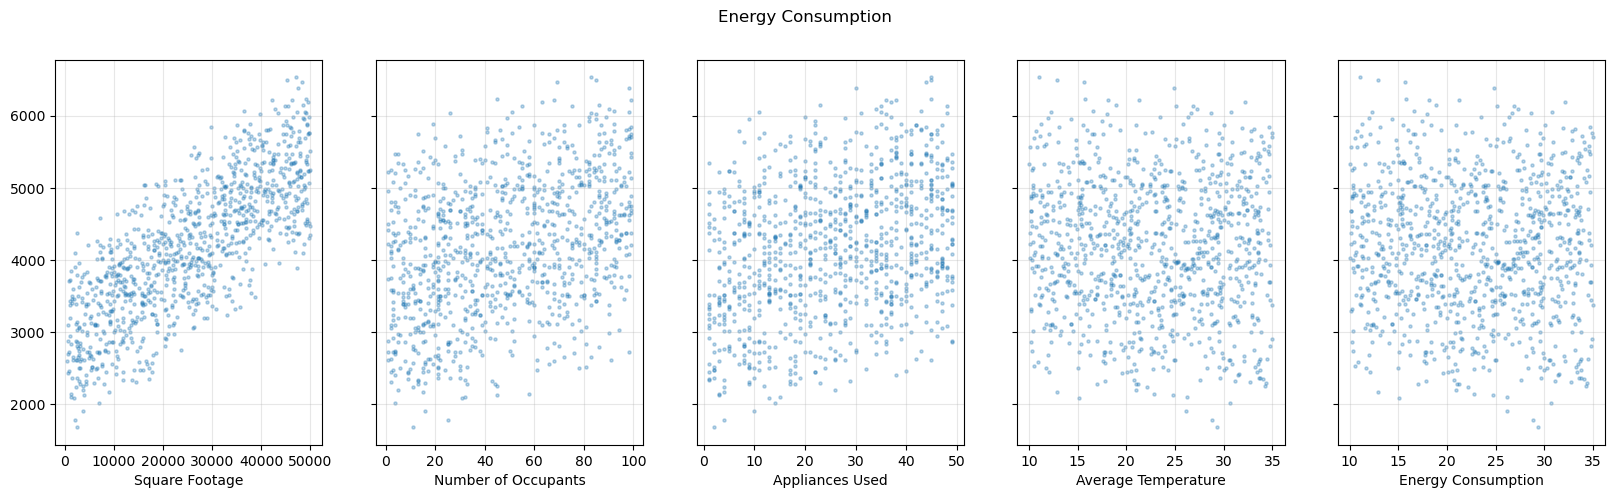

In [5]:
y = dados_treino['Energy Consumption']
num_var = len(variaveis_numericas)
fig, axs = plt.subplots(1,num_var,figsize=(20,5),sharey=True)
for i,var in enumerate(variaveis_numericas):
    if var != 'Energy Consumption': 
        X = dados_treino[var]
    axs[i].scatter(X,y,alpha=0.3,s=5)
    axs[i].set_xlabel(var)
    axs[i].grid(alpha=0.3)

plt.suptitle('Energy Consumption')
plt.show()

> Há uma tendência linear entre a metragem do imóvel *Square Footage* e o consumo de energia

Exibindo o gráfico de dispersão classificando por tipo de construção

In [6]:
dados_treino['Building Type'].value_counts()

Building Type
Residential    347
Commercial     336
Industrial     317
Name: count, dtype: int64

Primeiro irei analisar as classes separadamente

In [7]:
# Dicionário para representar as classes por cores
cores = {'Residential':'tab:blue',
         'Commercial':'tab:red',
         'Industrial':'tab:green'}

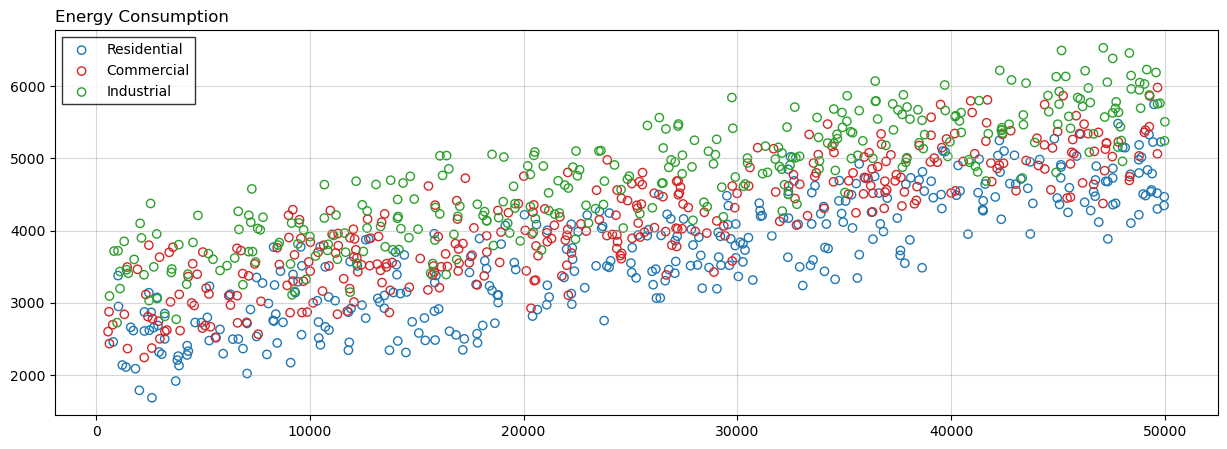

In [8]:
# Dados de entrada
X = dados_treino['Square Footage']
classes = dados_treino['Building Type']
fig = plt.figure(figsize=(15,5))
# Criar o scatterplot com loop para plotagem e legenda
for tipo_construcao, cor in cores.items():
    classe = (classes == tipo_construcao)
    plt.scatter(X[classe], y[classe], edgecolor=cor, color='None', label=tipo_construcao)

# Configurar a legenda
plt.title('Energy Consumption',loc='left')
plt.legend(loc='upper left', fancybox=False, edgecolor='k')
plt.grid(alpha=0.5)
plt.show()

In [9]:
# Desvio padrão do consumo para cada tipo de construção
dados_treino[['Building Type','Energy Consumption']].groupby(by='Building Type').std()

,Energy Consumption
Building Type,
Commercial,809.836992
Industrial,829.406280
Residential,847.616993


> Construções comerciais são as que tem menor desvio padrão. Irei considerá-las para o modelo linear

### Obtendo a reta de regressão

Assumindo que a verdadeira relação entre o consumo energético e a metragem da construção é linear, escrevemos:
$$
y = \beta_0 + \beta_1 X + \varepsilon
$$

* $y$: Consumo energético, *Energy Consumption*
* $X$: Metragem da construção, *Square Footage*
* $\varepsilon$: Erro nas medidas

Irei **estimar**, a partir dos dados de treino, os valores para os coeficientes. Sendo assim, consider:

* $\hat \beta_0$ : Estimador de $\beta_0$
* $\hat \beta_1$ : Estimador de $\beta_1$

### Estimando os coeficientes

$$
\mathbf{\beta = (X^{\top} X)^{-1}X^{\top}y}
$$

> A matriz $\mathbf{X}$ acima está incorporando o valor do intercepto.

In [10]:
import statsmodels.api as sm

Considerando somente os dados das construções comerciais

In [11]:
# Máscara com somente as observações de construções comerciais
filtro = (dados_treino['Building Type'] == 'Commercial')

# Definição das matrizes X e y a partir da máscara
X = dados_treino[filtro]['Square Footage']
y = dados_treino[filtro]['Energy Consumption']

In [12]:
# Adiciona a coluna com 1's na matriz X para considerar o intercepto
X_com_intercepto = sm.add_constant(X)

In [13]:
# Ajuste do modelo
modelo = sm.OLS(y,X_com_intercepto).fit()
b0_est,b1_est = modelo.params.values

Agora vamos construir a reta da regressão estimada a partir dos parâmetros $\hat \beta_0$ e $\hat \beta_1$

$$
\hat{y} = 2905 + 0.0501X
$$

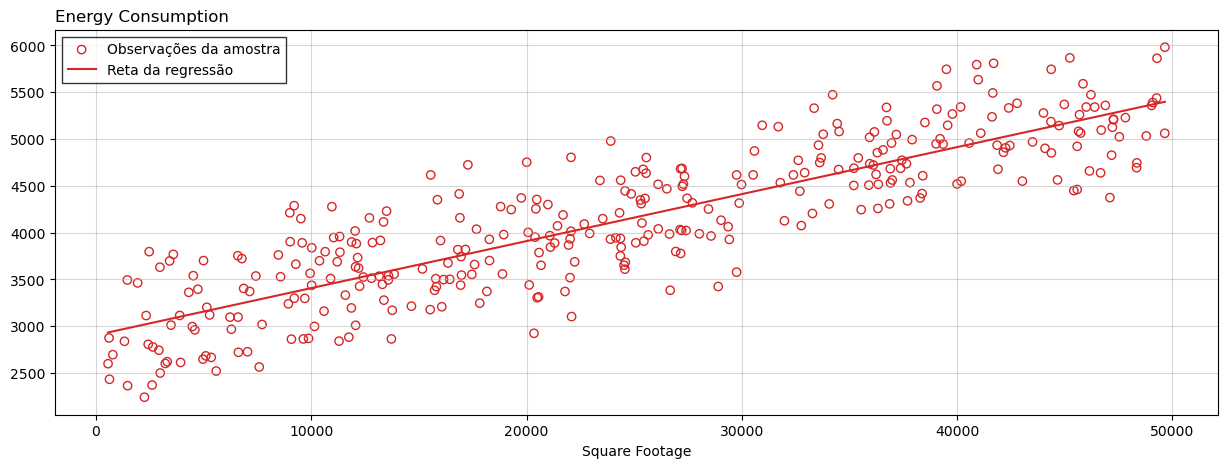

In [14]:
fig = plt.figure(figsize=(15,5))

# Dados para criar reta da regressão
X_sim_reg = np.linspace(X.min(),X.max(),100)
y_sim_reg = b0_est + b1_est * X_sim_reg

# Observações da amostra
plt.scatter(X,y,edgecolor='tab:red',color='None',label='Observações da amostra')
plt.plot(X_sim_reg, y_sim_reg, color='tab:red',label='Reta da regressão')

plt.title('Energy Consumption',loc='left')
plt.xlabel('Square Footage')
plt.legend(loc='upper left', fancybox=False, edgecolor='k')
plt.grid(alpha=0.5)
plt.show()

## Estimando os coeficientes manualmente
Vamos verificar e comparar os resultados obtidos pelo `statsmodel` com aqueles obtidos manualmente a partir das equações deduzidas para os estimadores. Lembrando que isso só é possível caso as premissas do modelo linear tenham sido satisfeitas

$$
\mathbf{\beta = (X^{\top} X)^{-1}X^{\top}y}
$$

> A matriz $\mathbf{X}$ acima está incorporando o valor do intercepto.

In [21]:
# Tamanho da amostra que considera somente as construções comerciais
n = X.shape[0]

In [23]:
# Adicionar intercepto à matriz X
X = np.vstack([np.ones(n), np.array(X)]).T  # Matriz X com intercepto (n x p)

In [24]:
# Calcular os coeficientes estimados (Beta)
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

In [33]:
coef_est = pd.DataFrame({
            'statsmodel':[b0_est,b1_est],
            'manual':beta_hat},
            index=['Intercepto','Coef.Angular'])

In [34]:
coef_est

,statsmodel,manual
Intercepto,2905.871675,2905.871675
Coef.Angular,0.050198,0.050198


Veja como os valores encontrados são idênticos numa grande precisão

In [35]:
# Calcular os resíduos
residuos = y - X @ beta_hat

In [41]:
# Verificando os resíduos calculados das duas formas
(round(modelo.resid,4) == round(residuos,4)).value_counts()

True    336
Name: count, dtype: int64

### Estimador da variância populacional

Onde $\hat \sigma ^2$ é o estimador da variância populacional, dado por:
$$
\hat \sigma ^2 = \frac{||e||^2}{n-p}
$$

* $e$ é o vetor dos resíduos
* $n-p$ é a quantidade de graus de liberdade

In [54]:
# Calcular o estimador da variância residual (sigma^2)
sigma_squared_hat = np.linalg.norm(residuos)**2 / (n - 1)

### Erro padrão

$$
\text{Var}(\hat \beta_j) = \hat \sigma^2 (\mathbf{X^{\top}X)^{-1}}
$$

In [55]:
# Calcular a matriz de variância dos coeficientes estimados
var_beta_hat = sigma_squared_hat * np.linalg.inv(X.T @ X)

In [62]:
# Resultados
SE_beta_0, SE_beta_1 = np.sqrt(var_beta_hat[0,0]), np.sqrt(var_beta_hat[1,1])

(44.70886005004251, 0.001591871213485365)

In [63]:
coef_est_SE = pd.DataFrame({
            'statsmodel':modelo.bse.values,
            'manual':[SE_beta_0, SE_beta_1]},
            index=['Intercepto','Coef.Angular'])

In [64]:
coef_est_SE

,statsmodel,manual
Intercepto,44.775739,44.708860
Coef.Angular,0.001594,0.001592


> A diferença é muito pequena (negligente) e pode ser atribuida ao erro de aproximação cometido na computação dos valores.

### Teste de hipóteses

A partir das expressões de $\hat \beta_1$ e $\hat \beta_0$, podemos mostrar que:

$$
\hat \beta_1 = \beta_1 + \frac{\sum (x_i - x)\varepsilon_i}{\sum(x_i-x)^2}
$$

$$
\hat \beta_0 = \beta_0 + \frac{\sum \varepsilon_i}{n} - \hat\beta_1 \bar x
$$

Veja, portanto, que $\hat\beta_1$ e $\hat\beta_0$ dependem linearmente de $\varepsilon_i$. Usando as propriedades das variáveis aleatórias, podemos concluir que os estimadores terão distribuição semelhante a distribuição da parcela de erro. Isto é, se o erro for gaussiano com média zero e desvio $\sigma^2$, os coeficientes também terão uma distribuição normal, mas com média centrada no valor real do coeficiente e desvio padrão igual ao erro padrão

Podemos mostrar que a expressão do erro padrão para os estimadores é:

$$
\text{SE}(\hat \beta_0)^2 = \sigma^2 \left[\frac{1}{n} + \frac{\bar {x^2}}{\sum(x_i - \bar x)^2}\right]
$$

$$
\text{SE}(\hat \beta_1)^2 = \frac{\sigma^2}{\sum(x_i - \bar x)^2}
$$

O intervalo de confiança para os estimadores $\hat\beta_j$ são da forma:

$$
\text{IC} = \hat\beta_j \pm t_{\alpha/2} \cdot \text{SE}(\hat\beta_j)
$$

Consultando os valores tabelados da distribuição $t$ para 2 graus de liberdade, temos $t_{\alpha/2}$ igual a 1.96. Substituindo na equação acima, podemos aproximar para:

$$
\text{IC} = \hat\beta_j \pm 2 \cdot \text{SE}(\hat\beta_j)
$$

In [69]:
from scipy.stats import t

In [78]:
# Parâmetros
alpha = 0.05
df = n-2

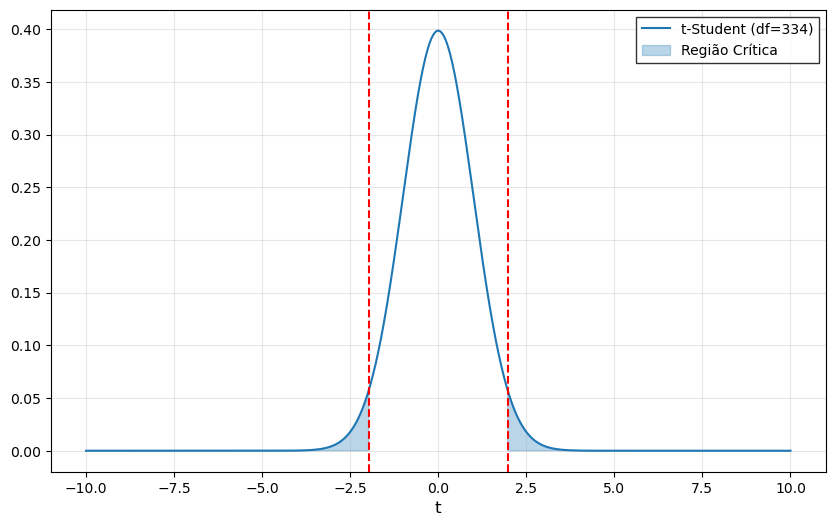

In [79]:
# Valores críticos para 5% de significância (teste bilateral)
t_critical = t.ppf(1 - alpha / 2, df)

# Geração de valores para a distribuição t
x = np.linspace(-10, 10, 1000)
y = t.pdf(x, df)

# Plot da distribuição t
plt.figure(figsize=(10, 6))
plt.plot(x, y, label=f"t-Student (df={df})", color="tab:blue")
plt.axvline(t_critical, color="red", linestyle="--")
plt.axvline(-t_critical, color="red", linestyle="--")
plt.fill_between(x, y, where=(x > t_critical) | (x < -t_critical), color="tab:blue", alpha=0.3, label="Região Crítica")
plt.xlabel("t", fontsize=12)
plt.legend(fancybox=False, edgecolor='k')
plt.grid(alpha=0.3)
plt.show()

Sendo assim, podemos plotar as *pdf's* de $\hat\beta_0$ e $\hat \beta_1$ do seguinte modo:

In [83]:
from scipy.stats import norm

In [84]:
b0 = np.linspace(b0_est - 4*SE_beta_0, b0_est + 4*SE_beta_0, 1000)
b1 = np.linspace(b1_est - 4*SE_beta_1, b1_est + 4*SE_beta_1, 1000)

pdf_b0 = norm.pdf(b0, loc=b0_est, scale=SE_beta_0)             # Cálculo da PDF
pdf_b1 = norm.pdf(b1, loc=b1_est, scale=SE_beta_1)             # Cálculo da PDF

(0.0, 0.05720205622069079)

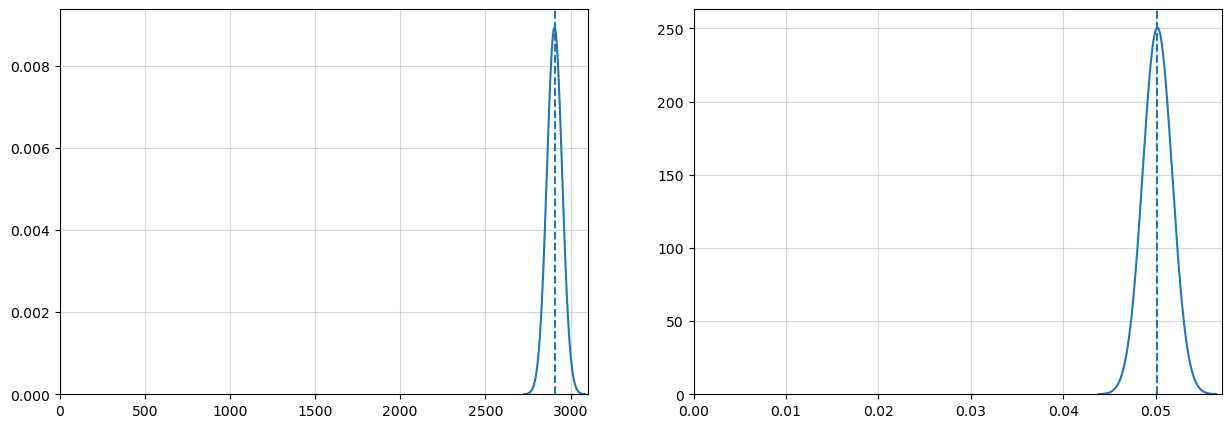

In [96]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

axes[0].plot(b0, pdf_b0)
axes[0].axvline(x=b0_est,ls='--',label=fr'$\hat\beta_0$')
axes[0].grid(alpha=0.5)
axes[0].set_ylim(0,)
axes[0].set_xlim(0,)

axes[1].plot(b1, pdf_b1)
axes[1].axvline(x=b1_est,ls='--',label=fr'$\hat\beta_1$')
axes[1].grid(alpha=0.5)
axes[1].set_ylim(0,)
axes[1].set_xlim(0,)